In [121]:
%pip install smdebug
%pip install jinja2==3.0


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached Jinja2-3.0.0-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import smdebug
from smdebug.profiler.utils import us_since_epoch_to_human_readable_time, ns_since_epoch_to_human_readable_time
from smdebug.core.utils import setup_profiler_report
import json
import datetime
import numpy as np

In [93]:
%matplotlib inline 

In [43]:
#report_path = "s3://sagemaker-us-east-1-431615879134/ipinyou-csv-g4dnxl-inmem2048-2022-08-13-18-29-02-415/rule-output/ProfilerReport/profiler-output/profiler-reports/"

In [44]:
#!aws s3 cp {report_path} ./tmp/ --recursive

In [123]:
def load_report(rule_name):
    try:
        report = json.load(open('./tmp/'+rule_name+'.json'))
        return report
    except FileNotFoundError:
        print (rule_name + ' not triggered')

In [124]:
def get_training_job_summary():
    job_statistics = {}
    report = load_report('MaxInitializationTime')
    if report:
        if "first" in report['Details']["step_num"] and "last" in report['Details']["step_num"]:
            first_step = report['Details']["step_num"]["first"]
            last_step = report['Details']["step_num"]["last"]
        tmp = us_since_epoch_to_human_readable_time(report['Details']['job_start'] * 1000000)
        date = datetime.datetime.strptime(tmp, '%Y-%m-%dT%H:%M:%S:%f')
        day = date.date().strftime("%m/%d/%Y")
        hour = date.time().strftime("%H:%M:%S")
        job_statistics["Start time"] = f"{hour} {day}"
        tmp = us_since_epoch_to_human_readable_time(report['Details']['job_end'] * 1000000)
        date = datetime.datetime.strptime(tmp, '%Y-%m-%dT%H:%M:%S:%f')
        day = date.date().strftime("%m/%d/%Y")
        hour = date.time().strftime("%H:%M:%S")
        job_statistics["End time"] = f"{hour} {day}"
        job_duration_in_seconds = int(report['Details']['job_end'] - report['Details']['job_start']) 
        job_statistics["Job duration"] = f"{job_duration_in_seconds} seconds"
        if "first" in report['Details']["step_num"] and "last" in report['Details']["step_num"]:
            tmp = us_since_epoch_to_human_readable_time(first_step)
            date = datetime.datetime.strptime(tmp, '%Y-%m-%dT%H:%M:%S:%f')
            day = date.date().strftime("%m/%d/%Y")
            hour = date.time().strftime("%H:%M:%S")
            job_statistics["Training loop start"] = f"{hour} {day}"
            tmp = us_since_epoch_to_human_readable_time(last_step)
            date = datetime.datetime.strptime(tmp, '%Y-%m-%dT%H:%M:%S:%f')
            day = date.date().strftime("%m/%d/%Y")
            hour = date.time().strftime("%H:%M:%S")
            job_statistics["Training loop end"] = f"{hour} {day}"
            training_loop_duration_in_seconds = int((last_step - first_step) / 1000000)
            job_statistics["Training loop duration"] = f"{training_loop_duration_in_seconds} seconds"
            initialization_in_seconds = int(first_step/1000000 - report['Details']['job_start'])
            job_statistics["Initialization time"] = f"{initialization_in_seconds} seconds"
            finalization_in_seconds = int(np.abs(report['Details']['job_end'] - last_step/1000000))
            job_statistics["Finalization time"] = f"{finalization_in_seconds} seconds"
            initialization_perc = int(initialization_in_seconds / job_duration_in_seconds * 100)
            job_statistics["Initialization"] = f"{initialization_perc} %"
            training_loop_perc = int(training_loop_duration_in_seconds / job_duration_in_seconds * 100)
            job_statistics["Training loop"] = f"{training_loop_perc} %"
            finalization_perc = int(finalization_in_seconds / job_duration_in_seconds * 100)
            job_statistics["Finalization"] = f"{finalization_perc} %"
        
        return job_statistics

In [125]:
def get_training_pval():
    report = load_report('OverallSystemUsage')
    rows = [] 
    units = {"CPU": "percentage", "CPU memory": "percentage", "GPU": "percentage", "Network": "bytes", "GPU memory": "percentage", "I/O": "percentage"}
    if report:
        for metric in report['Details']:
            for node_id in report['Details'][metric]:
                values = report['Details'][metric][node_id]
                rows.append([node_id, metric, units[metric], values['max'], values['p99'], values['p95'], values['p50'], values['min']])

        df = pd.DataFrame(rows) 
        df.columns = ['Node', 'metric', 'unit', 'max', 'p99', 'p95', 'p50', 'min']
        df2 = df.reset_index(drop=True)
        return df2


In [134]:
with open('trail_two.txt','r') as fl:
    p = fl.read()
    p = p.split('\n')[:-1]

In [ ]:
out = {}
for job in p:
    print(job)
    !mkdir ./tmp/
    report_folder = f's3://sagemaker-us-east-1-431615879134/{job}/rule-output/ProfilerReport/profiler-output/profiler-reports/'
    print(report_folder)
    # copy profile info to local tmp
    !aws s3 cp {report_folder} ./tmp/ --recursive
    
    # get summary stats
    stats = get_training_job_summary()
    out[job]={'stats': stats}
    
    # get gpu / cpu metrics 
    pvals = get_training_pval()
    out[job]['pvals'] = pvals
    
    !rm ./tmp/ -rf    

In [136]:
init = [int(out[q]['stats']['Initialization time'].split(' ')[0]) for q in out]
train = [int(out[q]['stats']['Training loop duration'].split(' ')[0]) for q in out]
final = [int(out[q]['stats']['Finalization time'].split(' ')[0]) for q in out]

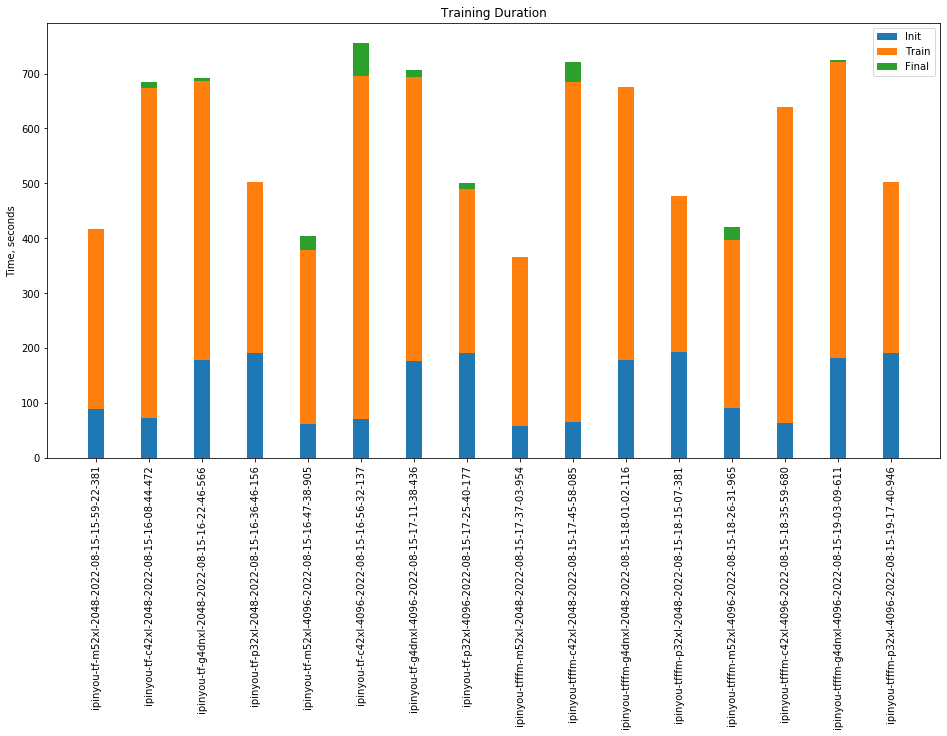

In [137]:
width = 0.3
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(p, init, width, label='Init')
ax.bar(p, train, width, bottom=init, label='Train')
ax.bar(p, final, width, bottom=np.add(train,init), label='Final')

ax.set_ylabel('Time, seconds')
ax.set_title('Training Duration')
ax.legend()
plt.xticks(rotation=90);
plt.savefig('tftraining_duration.png',bbox_inches='tight')


In [138]:
CPU = []
GPU = []
IO = []
CPUmem = []
GPUmem = []
pvalue = 'p95'

for job in out:
    
    df = out[job]['pvals']
    
    if sum(df['metric'].isin(['GPU'])) > 0:
        GPU.append(df[df['metric']=='GPU'][pvalue].values[0])
    else: GPU.append(0)
        
    if sum(df['metric'].isin(['CPU'])) > 0:
        CPU.append(df[df['metric']=='CPU'][pvalue].values[0])
    else: CPU.append(0) 
    
    if sum(df['metric'].isin(['I/O'])) > 0:
        IO.append(df[df['metric']=='I/O'][pvalue].values[0])
    else: IO.append(0)
        
    if sum(df['metric'].isin(['CPU memory'])) > 0:
        CPUmem.append(df[df['metric']=='CPU memory'][pvalue].values[0])
    else: CPUmem.append(0)
        
    if sum(df['metric'].isin(['GPU memory'])) > 0:
        GPUmem.append(df[df['metric']=='GPU memory'][pvalue].values[0])
    else: GPUmem.append(0)
    
    

In [139]:
a = [*range(0,len(p))]

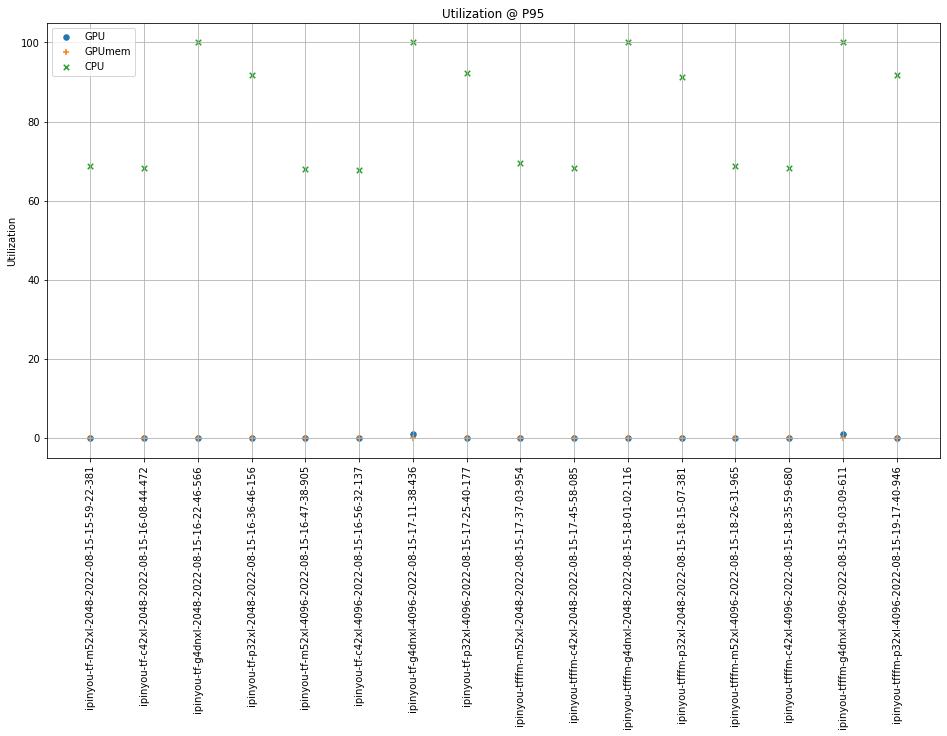

In [140]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(a, GPU, s=30., marker = 'o', label='GPU')
ax.scatter(a, GPUmem, s=30, marker = '+', label='GPUmem')
ax.scatter(a, CPU, s=30., marker = 'x', label='CPU')

ax.set_ylabel('Utilization')
ax.set_title('Utilization @ P95')
ax.legend()
ax.grid()
plt.xticks(a,p,rotation=90);
plt.savefig('tftraining_pvals.png',bbox_inches='tight')

In [ ]:
width = 0.3
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(p, init, width, label='Init')
ax.bar(p, train, width, bottom=init, label='Train')
ax.bar(p, final, width, bottom=np.add(train,init), label='Final')

ax.set_ylabel('Time, seconds')
ax.set_title('Training Duration')
ax.legend()
plt.xticks(rotation=90),


In [31]:
def get_training_pval():
    report = load_report('OverallSystemUsage')
    rows = [] 
    units = {"CPU": "percentage", "CPU memory": "percentage", "GPU": "percentage", "Network": "bytes", "GPU memory": "percentage", "I/O": "percentage"}
    if report:
        for metric in report['Details']:
            for node_id in report['Details'][metric]:
                values = report['Details'][metric][node_id]
                rows.append([node_id, metric, units[metric], values['max'], values['p99'], values['p95'], values['p50'], values['min']])

        df = pd.DataFrame(rows) 
        df.columns = ['Node', 'metric', 'unit', 'max', 'p99', 'p95', 'p50', 'min']
        df2 = df.reset_index(drop=True)
        return df2


In [42]:
report = load_report('MaxInitializationTime')

In [43]:
report

{'RuleTriggered': 0,
 'Violations': 0,
 'Details': {'step_num': {'first': 1660415630607312, 'last': 1660415695627014},
  'job_start': 1660415444.219979,
  'job_end': 1660415699.833861},
 'Datapoints': 9705,
 'RuleParameters': 'threshold:20'}

In [32]:
df2

,Node,metric,unit,max,p99,p95,p50,min
0,algo-1,Network,bytes,106878.34,0.00,0.00,0.00,0.00
1,algo-1,GPU,percentage,9.00,8.00,7.00,0.00,0.00
2,algo-1,CPU,percentage,100.00,100.00,99.22,84.56,0.00
3,algo-1,CPU memory,percentage,38.62,33.63,27.82,9.79,7.17
4,algo-1,GPU memory,percentage,2.00,2.00,2.00,0.00,0.00
5,algo-1,I/O,percentage,57.03,50.07,43.31,0.00,0.00


In [9]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

In [5]:
job_name = 'ipinyou-csv-g4dnxl-inmem4096-2022-08-13-18-54-11-214'

In [6]:
tj = TrainingJob(job_name, 'us-east-1')

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-431615879134/', 'ProfilingIntervalInMilliseconds': 200, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 7, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 5, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 13, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 9, "NumSteps": 3, "ProfilerName": "cprofile", "cProfileTimer": "default", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 15, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-431615879134/ipinyou-csv-g4dnxl-inmem4096-2022-08-13-18-54-11-214/profiler-output


In [7]:
# Wait for the data to be available
tj.wait_for_sys_profiling_data_to_be_available()
tj.wait_for_framework_profiling_data_to_be_available()
# Get the metrics reader
system_metrics_reader = tj.get_systems_metrics_reader()
framework_metrics_reader = tj.get_framework_metrics_reader()
# Refresh the event file list
system_metrics_reader.refresh_event_file_list()
framework_metrics_reader.refresh_event_file_list()



Profiler data from system is available
[2022-08-15 16:26:20.861 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:6706 INFO algorithm_metrics_reader.py:192] S3AlgorithmMetricsReader created with bucket:sagemaker-us-east-1-431615879134 and prefix:ipinyou-csv-g4dnxl-inmem4096-2022-08-13-18-54-11-214/profiler-output/framework/


 Profiler data from framework is available
Found recorded framework annotations. Latest available timestamp microsseconds_since_epoch is:1660417175562649 , human_readable_timestamp in utc: 2022-08-13T18:59:35:562649


In [ ]:
def preprocess_system_metrics(self, events, system_metrics):

    # read all available system metric events and store them in dict
    for event in events:
        if self.show_workers is True:
            event_unique_id = f"{event.dimension}-nodeid:{str(event.node_id)}"
        else:
            event_unique_id = event.dimension
        if event_unique_id not in system_metrics:
            system_metrics[event_unique_id] = {}
            self.available_dimensions.append(event_unique_id)
        if event.name not in system_metrics[event_unique_id]:
            system_metrics[event_unique_id][event.name] = []
            self.available_events.append(event.name)
        system_metrics[event_unique_id][event.name].append([event.timestamp, event.value])

    for dimension in system_metrics:
        for event in system_metrics[dimension]:
            # convert to numpy
            system_metrics[dimension][event] = np.array(system_metrics[dimension][event])

            # subtract first timestamp
            system_metrics[dimension][event][:, 0] = (
                system_metrics[dimension][event][:, 0] - self.start
            )

    # compute total utilization per event dimension
    for event_dimension in system_metrics:
        n = len(system_metrics[event_dimension])
        total = [sum(x) for x in zip(*system_metrics[event_dimension].values())]
        system_metrics[event_dimension]["total"] = np.array(total) / n
        self.available_events.append("total")

    self.filtered_events = []
    print(f"select events:{self.select_events}")
    self.filtered_dimensions = []
    print(f"select dimensions:{self.select_dimensions}")
    for metric in self.select_events:
        r = re.compile(r".*" + metric)
        self.filtered_events.extend(list(filter(r.search, self.available_events)))
    self.filtered_events = set(self.filtered_events)
    print(f"filtered_events:{self.filtered_events}")
    for metric in self.select_dimensions:
        r = re.compile(metric)  # + r".*")
        self.filtered_dimensions.extend(list(filter(r.search, self.available_dimensions)))
    self.filtered_dimensions = set(self.filtered_dimensions)
    print(f"filtered_dimensions:{self.filtered_dimensions}")
    return system_metrics

In [10]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader, 
    framework_metrics_reader,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"] 
)

[2022-08-15 16:27:15.469 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:6706 INFO metrics_reader_base.py:134] Getting 5 event files
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1'}
